# 프로젝트: 폐렴 진단기 성능 개선

## 실험환경 setup
Batch size, Epoch 등을 바꿔볼 수 있겠지?

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16
# BATCH_SIZE = 32

# X-RAY 이미지 사이즈 변수
# IMAGE_SIZE = [180, 180]
IMAGE_SIZE = [200, 200]

# EPOCH 크기 변수
# EPOCHS = 25
EPOCHS = 30

## 데이터 준비하기

데이터가 충분하지 않으니... augmentation을 해보는건 어떨까??   
근데, 의료영상의 경우 일반적인 이미지처리에서 사용하는 augmentation이 항상 도움이 된다고 말하기도 어렵다. 육안으로도 구분하기 어려운 미묘한 차이로 병을 구분하는건데, 노이즈 등 부수효과가 오히려 판단에 방해를 줄 수도 있기 때문!   
따라서, 의료영상에서 augmentation 도입은 신중해야한다.

In [4]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


In [11]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  True


In [15]:
# 좌우반전만 해볼까??

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

학습용 데이터 시각화해서 확인해보기

In [17]:
image_batch, label_batch = next(iter(train_ds))

image_batch[0].shape

TensorShape([200, 200, 3])

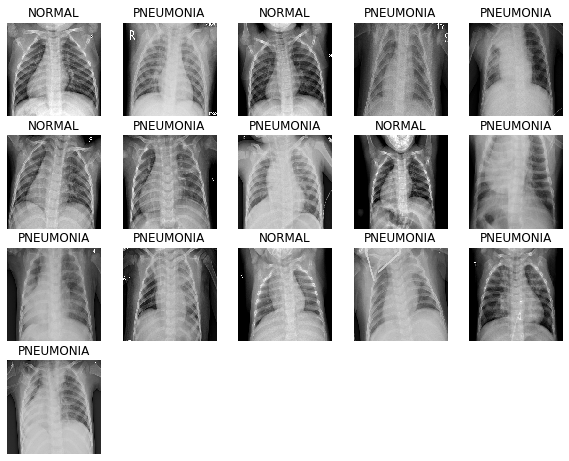

In [18]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        # print(image_batch[n])
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

conv filter, 채널 개수, activation, 모델구조 등을 다양하게 바꿔볼 수 있다.   
그리고 BN과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구조로 처음에 진행했잖아?? 일반적으로 사용하는 형태는 아니지만, 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다.   
그렇다면, BN 혹은 Dropout을 빼보는 실험을 해볼 수 있겠지?? 혹은 Dropout 비율을 변경해볼 수도 있겠지?

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate=0.3):
    if dropout_rate == 0:
        block = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.BatchNormalization(),
        ])
    else:
        block = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(dropout_rate)
        ])
    
    return block

In [21]:
def build_model(is_dropout=True):

    dropout_rates = [0.7,0.5,0.3]
    if not is_dropout:
        dropout_rates = [0]*3     
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(BATCH_SIZE, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(BATCH_SIZE, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, dropout_rates[0]),
        dense_block(128, dropout_rates[1]),
        dense_block(64, dropout_rates[2]),    
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리

In [22]:
import keras
from keras import backend as K
import tensorflow as tf

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, True), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, False), y_pred, tf.zeros_like(y_pred))
# 0과 1에 대해 loss 각각 계산해서 합치는 중
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Compile our model
# adam = Adam(lr=0.0001)
# model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)

In [23]:
# normal 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 

# pneumonia 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# 전체 데이터 건수에 반비례하도록 설정된다.

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


## 모델 훈련

In [24]:
with tf.device('/GPU:0'):

    dropout_BN_model = build_model(is_dropout=True)
    dropout_BN_model_focal = build_model(is_dropout=True)
    BN_model = build_model(is_dropout=False)
    BN_model_focal = build_model(is_dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    dropout_BN_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        # loss=[focal_loss],
        metrics=METRICS
    )

    dropout_BN_model_focal.compile(
        optimizer='adam',
        # loss='binary_crossentropy',
        loss=[focal_loss],
        metrics=METRICS
    )

    BN_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        # loss=[focal_loss],
        metrics=METRICS
    )

    BN_model_focal.compile(
        optimizer='adam',
        # loss='binary_crossentropy',
        loss=[focal_loss],
        metrics=METRICS
    )

    models = [
        ['dropout_BN_model',dropout_BN_model],
        ['dropout_BN_model_focal',dropout_BN_model_focal],
        ['BN_model',BN_model],
        ['BN_model_focal',BN_model_focal],
    ]

In [25]:
import pickle
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

savemodel_path = './history' 


In [26]:
def train_and_save (model_name, model):
    with tf.device('/GPU:0'):
        checkpoint_path = './model/{}/cp.ckpt'.format(model_name)
        checkpoint_dir = os.path.dirname(checkpoint_path)

        # 모델의 가중치를 저장하는 콜백 만들기
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=1)

        hist = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
            callbacks=[cp_callback]
        )

        with open(savemodel_path+'/'+model_name, 'wb') as file:
            model_history= History_trained_model(hist.history, hist.epoch, hist.params)
            pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [27]:
train_and_save(models[0][0],models[0][1])

Epoch 1/30
261/261 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8314 - precision: 0.9643 - recall: 0.8045
Epoch 00001: saving model to ./model/cp-dropout_BN_model.ckpt
261/261 [==============================] - 30s 114ms/step - loss: 0.3514 - accuracy: 0.8314 - precision: 0.9643 - recall: 0.8045 - val_loss: 0.7154 - val_accuracy: 0.7192 - val_precision: 0.7192 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9126 - precision: 0.9748 - recall: 0.9064
Epoch 00002: saving model to ./model/cp-dropout_BN_model.ckpt
261/261 [==============================] - 29s 111ms/step - loss: 0.2205 - accuracy: 0.9126 - precision: 0.9748 - recall: 0.9064 - val_loss: 1.6923 - val_accuracy: 0.7192 - val_precision: 0.7192 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9272 - precision: 0.9777 - recall: 0.9239
Epoch 00003: saving model to ./model/cp-dropo

In [27]:
train_and_save(models[1][0],models[1][1])

Epoch 1/30
261/261 [==============================] - ETA: 0s - loss: 1.2677 - accuracy: 0.7610 - precision: 0.9340 - recall: 0.7314
Epoch 00001: saving model to ./model/dropout_BN_model_focal/cp.ckpt
261/261 [==============================] - 29s 112ms/step - loss: 1.2677 - accuracy: 0.7610 - precision: 0.9340 - recall: 0.7314 - val_loss: 1.8555 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.8599 - precision: 0.9607 - recall: 0.8471
Epoch 00002: saving model to ./model/dropout_BN_model_focal/cp.ckpt
261/261 [==============================] - 28s 108ms/step - loss: 0.6419 - accuracy: 0.8599 - precision: 0.9607 - recall: 0.8471 - val_loss: 5.2009 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8968 - precision: 0.9709 - recall: 0.8883
Epoch 00003: saving model to ./mo

In [27]:
train_and_save(models[2][0],models[2][1])

Epoch 1/30
261/261 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.8898 - precision: 0.9696 - recall: 0.8785
Epoch 00001: saving model to ./model/BN_model/cp.ckpt
261/261 [==============================] - 27s 105ms/step - loss: 0.2589 - accuracy: 0.8898 - precision: 0.9696 - recall: 0.8785 - val_loss: 0.6481 - val_accuracy: 0.7577 - val_precision: 0.7577 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9339 - precision: 0.9798 - recall: 0.9296
Epoch 00002: saving model to ./model/BN_model/cp.ckpt
261/261 [==============================] - 27s 102ms/step - loss: 0.1754 - accuracy: 0.9339 - precision: 0.9798 - recall: 0.9296 - val_loss: 1.3394 - val_accuracy: 0.7567 - val_precision: 0.7567 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9373 - precision: 0.9812 - recall: 0.9328
Epoch 00003: saving model to ./model/BN_model/cp.ckpt
261/261

In [28]:
train_and_save(models[3][0],models[3][1])

Epoch 1/30
261/261 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.8673 - precision: 0.9720 - recall: 0.8713
Epoch 00001: saving model to ./model/BN_model_focal/cp.ckpt
261/261 [==============================] - 25s 94ms/step - loss: 0.5386 - accuracy: 0.8673 - precision: 0.9720 - recall: 0.8713 - val_loss: 1.7344 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.9159 - precision: 0.9776 - recall: 0.9070
Epoch 00002: saving model to ./model/BN_model_focal/cp.ckpt
261/261 [==============================] - 25s 97ms/step - loss: 0.3295 - accuracy: 0.9159 - precision: 0.9776 - recall: 0.9070 - val_loss: 3.2345 - val_accuracy: 0.7548 - val_precision: 0.7548 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.9248 - precision: 0.9816 - recall: 0.9154
Epoch 00003: saving model to ./model/BN_model_focal

## 결과 확인과 시각화

### 훈련 과정 시각화

In [29]:
histories = []
for model in models:

    model_name = model[0]
    with open(savemodel_path+'/'+model_name, 'rb') as file:        
        histories.append([model_name, pickle.load(file)])


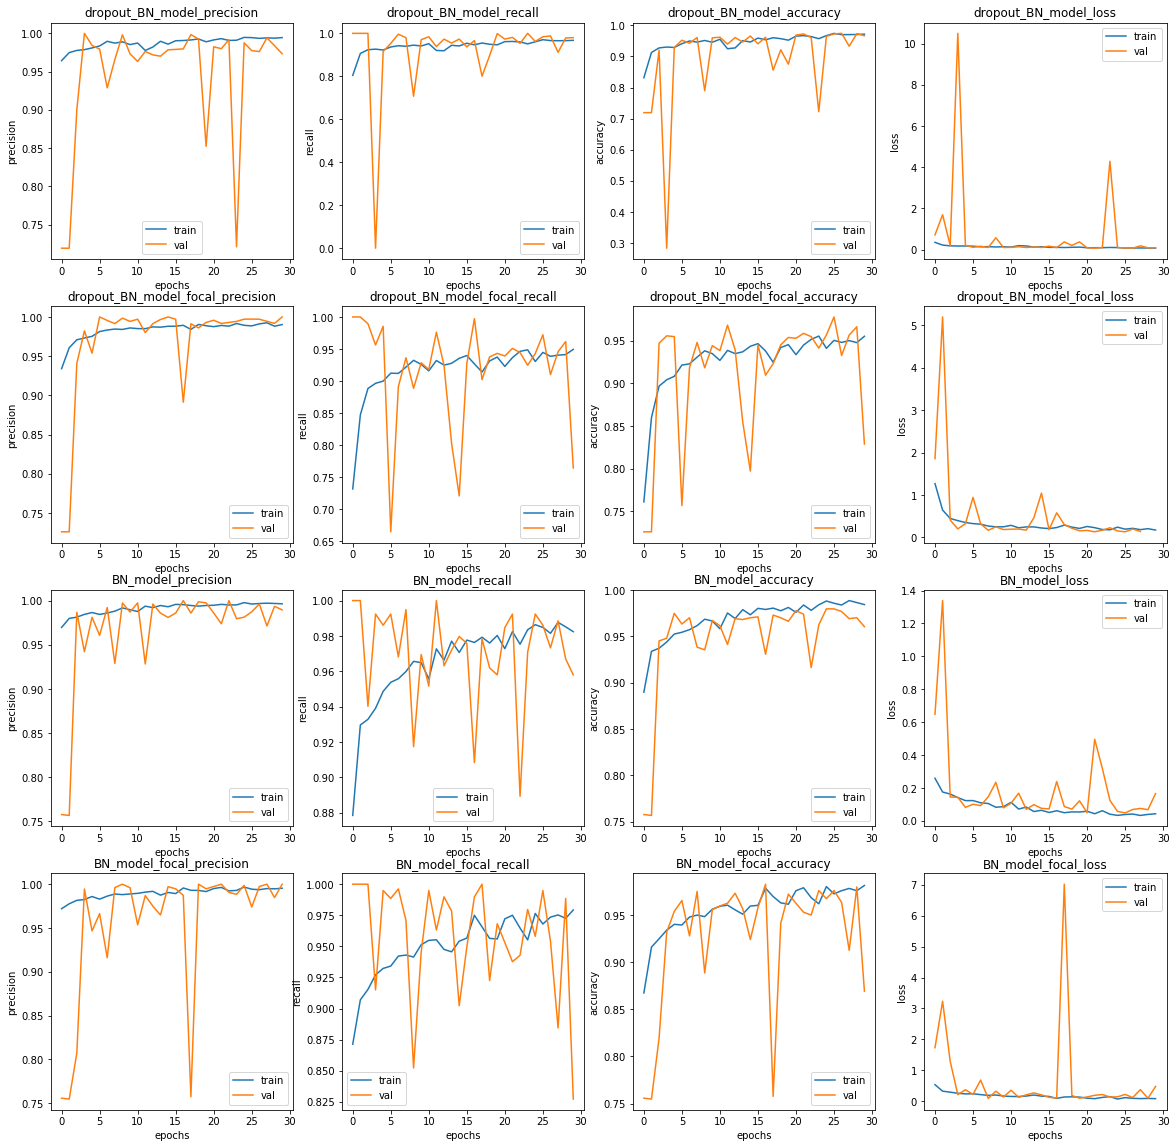

In [34]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

# ax = ax.ravel()

for idx,history_info in enumerate(histories):
    model_name = history_info[0]
    history = history_info[1]
    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[idx][i].plot(history.history[met])
        ax[idx][i].plot(history.history['val_' + met])
        ax[idx][i].set_title(model_name+'_'+met)
        ax[idx][i].set_xlabel('epochs')
        ax[idx][i].set_ylabel(met)
        ax[idx][i].legend(['train', 'val'])

### 테스트 데이터로 모델 평가

In [31]:
for model in models:
    model_name = model[0]
    model = model[1]
    checkpoint_path = './model/{}/cp.ckpt'.format(model_name)
    model.load_weights(checkpoint_path)
    print('=============================================')
    print(model_name)
    loss, acc, prec, rec = model.evaluate(test_ds)


dropout_BN_model
39/39 [==============================] - 2s 60ms/step - loss: 1.4899 - accuracy: 0.7324 - precision: 0.8630 - recall: 0.8828
dropout_BN_model_focal
39/39 [==============================] - 2s 57ms/step - loss: 1.2521 - accuracy: 0.8590 - precision: 0.8755 - recall: 0.8749
BN_model
39/39 [==============================] - 2s 59ms/step - loss: 2.0138 - accuracy: 0.8446 - precision: 0.8097 - recall: 0.9821
BN_model_focal
39/39 [==============================] - 2s 61ms/step - loss: 1.0303 - accuracy: 0.9006 - precision: 0.9100 - recall: 0.9333


테스트 데이터에 대한 accuracy로 판단했을 때, 가장 높은 수치는 90% 가량이 나왔다. Batch Normalization 만을 사용하고, focal loss를 사용한 모델을 30 회 학습하였을 때 얻을 수 있는 결과이다.   

# 결과보고서

학습 노드에서 정확도를 기준으로 이야기 하였기 때문에, 정확도를 기준으로 판단하면 위에서도 언급했던 것처럼 BN만을 사용하고(Dropout 같이쓰지 않음) loss는 focal loss를 사용한 모델을 30회 학습한 경우가 90% 가량으로 가장 높은 정확도를 보여줬다.   
하지만, 병의 진단이라는 것이 accuracy 보다는 recall 값이 더 중요할 수 있다는 관점에서 바라보자면, BN만을 사용하고 loss는 binary_CE 를 사용한 모델을 30회 학습한 경우가 recall 값이 98% 정도로 가장 높은 수치를 보여주었다.